In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pdb
import dp_accounting
from dp_accounting.pld import privacy_loss_distribution

Num GPUs Available:  1


In [2]:
class Preprocessing:
    def __init__(self):
        self.train_data, self.val_data, self.test_data = self.load_data()

    def load_data(self):
        (train_X, train_y), (test_X, test_y) = mnist.load_data()
        train_X = train_X.reshape(60000, 784) / 255.0
        test_X = test_X.reshape(10000, 784) / 255.0

        train_X, val_X = train_X[:54000], train_X[54000:]
        train_y, val_y = train_y[:54000], train_y[54000:]

        train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
        val_data = tf.data.Dataset.from_tensor_slices((val_X, val_y)).batch(512)
        test_data = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(512)
        
        return train_data, val_data, test_data

    def get_train_data(self):
        return self.train_data

    def get_test_data(self):
        return self.test_data

    def get_val_data(self):
        return self.val_data

In [3]:
class DPSGD:
    def __init__(self, train_data, val_data, test_data, sigma, batch_size, delta=1e-5):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.C = 0.1
        self.sigma = sigma
        self.batch_size = batch_size
        self.learning_rate = 0.05
        self.epochs = 1000
        self.delta = delta
        self.model = self.Simple_NN()
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.pld = privacy_loss_distribution.from_gaussian_mechanism(
            self.sigma, value_discretization_interval=1e-3
        )
    
    def Simple_NN(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(784,1)),
            tf.keras.layers.Dense(128, activation='relu'),
            #tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10)
        ])
        return model
        
    def train(self, privacy_budget=30):
        start_time = time.time()
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        valid_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

        train_loss_scores = []
        valid_loss_scores = []
        train_acc_scores = []
        valid_acc_scores = []
        test_acc_scores = []
        
        for epoch in range(self.epochs):
            batch = self.train_data.shuffle(buffer_size=54000).batch(self.batch_size)
            images, labels = next(iter(batch))

            with tf.GradientTape() as tape:
                predict = self.model(images, training=True)
                loss = self.loss_fn(labels, predict)
            grads = tape.gradient(loss, self.model.trainable_variables)

            clipped_grads = [tf.clip_by_norm(g, clip_norm=self.C) for g in grads]

            noisy_grads = []
            for g in clipped_grads:
                noise = tf.random.normal(
                    shape=g.shape,  
                    stddev=self.sigma * self.C 
                )
                noisy_grad = g + noise/self.batch_size
                noisy_grads.append(noisy_grad)

            self.optimizer.apply_gradients(zip(noisy_grads, self.model.trainable_variables))
            train_acc_metric.update_state(labels, predict)

            # Validation Metrics
            if epoch % 100 == 0:
                valid_acc_metric.reset_states()
                valid_images, valid_labels = next(iter(self.val_data))
                valid_predict = self.model(valid_images, training=False)
                valid_loss = self.loss_fn(valid_labels, valid_predict)
                valid_acc_metric.update_state(valid_labels, valid_predict)
                valid_loss_scores.append(valid_loss.numpy())
                valid_acc_scores.append(valid_acc_metric.result().numpy() * 100)
                print(f"Epoch {(epoch + 1)//100} Validation Loss: {valid_loss.numpy():.4f}, "f"Validation Accuracy: {valid_acc_metric.result().numpy() * 100:.2f}%")
                
                # Training Metrics
                train_acc = train_acc_metric.result().numpy() * 100
                train_loss_scores.append(loss.numpy())
                train_acc_scores.append(train_acc)
                print(f"Epoch {(epoch + 1)//100} Training Accuracy: {train_acc:.2f}%")
                train_acc_metric.reset_states()  
                
                # Test Metrics
                test_images, test_labels = next(iter(self.test_data)) 
                test_predict = self.model(test_images, training=False)
                test_acc = tf.keras.metrics.SparseCategoricalAccuracy()
                test_acc.update_state(test_labels, test_predict)
                test_acc_scores.append(test_acc.result().numpy() * 100)
                print(f"Epoch {(epoch + 1)//100} Test Accuracy: {test_acc.result().numpy() * 100:.2f}%")

        end_time = time.time()
        print(f"Training completed in {end_time - start_time:.2f} seconds.")
        composed_pld = self.pld.self_compose(self.epochs)
        epsilon = composed_pld.get_epsilon_for_delta(self.delta)
        print(f"After {self.epochs} training steps, the model satisfies ({epsilon:.3f}, {self.delta})-DP.")
        return train_loss_scores, valid_loss_scores, train_acc_scores, valid_acc_scores, test_acc_scores
    
    def test_model(self):
        test_loss = tf.keras.metrics.Mean(name='test_loss')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

        for images, labels in self.test_data:
            predict = self.model(images, training=False)
            loss = self.loss_fn(labels, predict)
            test_loss.update_state(loss)
            test_accuracy.update_state(labels, predict)

        return test_loss.result(), test_accuracy.result()

In [4]:
def plot_results(train_loss_scores, valid_loss_scores, train_acc_scores, valid_acc_scores, test_acc_scores):
    length = len(train_loss_scores)
    epochs_range = range(1, length+1)
    
    plt.plot(epochs_range, train_loss_scores, label='Training loss', marker='o', markersize=3.5, linestyle='-', color='b')
    plt.plot(epochs_range, valid_loss_scores, label='Validation loss', marker='o', markersize=3.5, linestyle='-', color='r')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(epochs_range, train_acc_scores, label='Training accuracy', marker='o', markersize=3.5, linestyle='-', color='b')
    plt.plot(epochs_range, valid_acc_scores, label='Validation accuracy', marker='o', markersize=3.5, linestyle='-', color='r')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs_range, test_acc_scores, label='Test accuracy', marker='o', markersize=3.5, linestyle='-', color='g')
    plt.plot(epochs_range, train_acc_scores, label='Training accuracy', marker='o', markersize=3.5, linestyle='-', color='b')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [5]:
data_prep = Preprocessing()
train_data = data_prep.get_train_data()
test_data = data_prep.get_test_data()
val_data = data_prep.get_val_data()

In [6]:
noisy_model = DPSGD(train_data, val_data, test_data, 7, 512)

Epoch 0 Validation Loss: 2.3672, Validation Accuracy: 13.09%
Epoch 0 Training Accuracy: 11.52%
Epoch 0 Test Accuracy: 13.09%
Epoch 1 Validation Loss: 1.7767, Validation Accuracy: 59.38%
Epoch 1 Training Accuracy: 37.68%
Epoch 1 Test Accuracy: 54.30%
Epoch 2 Validation Loss: 1.2997, Validation Accuracy: 72.66%
Epoch 2 Training Accuracy: 66.69%
Epoch 2 Test Accuracy: 69.34%
Epoch 3 Validation Loss: 0.9497, Validation Accuracy: 78.91%
Epoch 3 Training Accuracy: 75.28%
Epoch 3 Test Accuracy: 76.17%
Epoch 4 Validation Loss: 0.7267, Validation Accuracy: 81.64%
Epoch 4 Training Accuracy: 80.90%
Epoch 4 Test Accuracy: 81.25%
Epoch 5 Validation Loss: 0.5934, Validation Accuracy: 84.77%
Epoch 5 Training Accuracy: 84.10%
Epoch 5 Test Accuracy: 83.79%
Epoch 6 Validation Loss: 0.5080, Validation Accuracy: 86.52%
Epoch 6 Training Accuracy: 85.74%
Epoch 6 Test Accuracy: 85.94%
Epoch 7 Validation Loss: 0.4512, Validation Accuracy: 88.09%
Epoch 7 Training Accuracy: 87.08%
Epoch 7 Test Accuracy: 87.50%


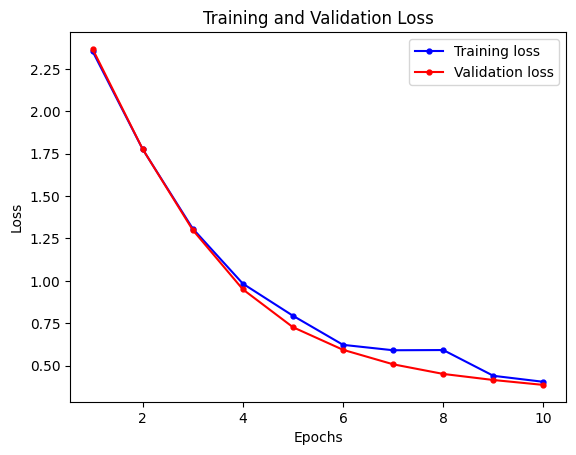

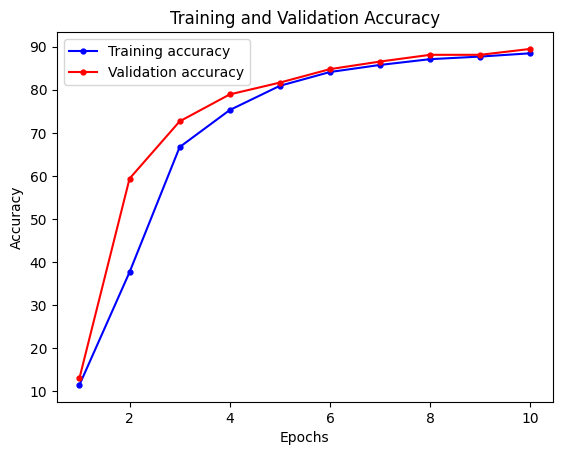

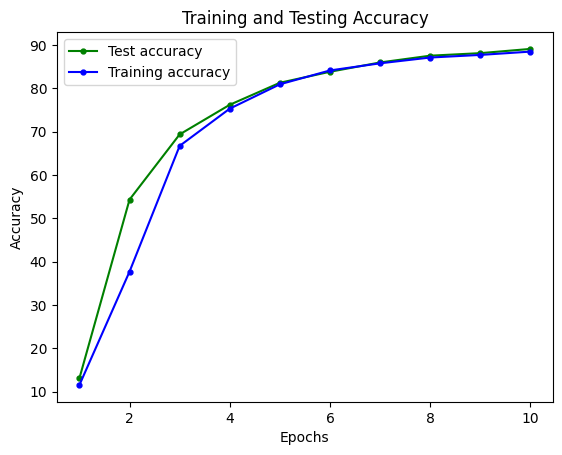

In [7]:
TrLS_noisy, VlLS_noisy, TrAC_noisy, VlAC_noisy, TeAC_noisy = noisy_model.train()
test_LS_noisy, test_AC_noisy = noisy_model.test_model()
print(f'\nTest Loss: {test_LS_noisy:.4f}, Test Accuracy: {test_AC_noisy*100:.2f}%') 
plot_results(TrLS_noisy, VlLS_noisy, TrAC_noisy, VlAC_noisy, TeAC_noisy)